## Get data

### Get data from yfinance

In [3]:
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override()
import pandas as pd

ticker_list=["AAPL", "MSFT", "AMZN", "FB", "TSLA", "NVDA", "GOOG", "GOOGL", "CSCO", "AVGO"]
today = date.today()
# We can get data by our choice by giving days bracket
start_date= "2013-01-01"
end_date="2020-11-30"

files=[]
def getData(ticker):
    data = pdr.get_data_yahoo(ticker, start=start_date, end=today)
    # dataname= ticker+"_"+str(today)
    files.append((data,ticker))
    
for tik in ticker_list:
    getData(tik)
    
    



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Setup firebase

In [2]:
import firebase_admin

cred_obj = firebase_admin.credentials.Certificate('../../../fyp2022-stockpriceprediction-firebase-adminsdk-ku62m-f9ed330292.json')
fyp_app = firebase_admin.initialize_app(cred_obj, {
	'databaseURL':"https://fyp2022-stockpriceprediction-default-rtdb.asia-southeast1.firebasedatabase.app/",
	'storageBucket': 'fyp2022-stockpriceprediction.appspot.com'
	})

### Upload data into firebase

In [6]:
from firebase_admin import db
from datetime import datetime as dt

for file in files:
    
    tick = file[1]
    data = file[0]
    data['Ticker'] = tick
    
    #convert date index to string, as firebsae cant have datetime as an index
    data.index = data.index.strftime("%Y-%m-%d")
    
    #convert the dataframe to json/dictionary
    data_dict = data.to_dict(orient="index")
    
    #upload it to the database
    ref = db.reference("/data/"+tick)
    ref.set(data_dict)

### Get data from firebase database

In [3]:
from matplotlib import pyplot as plt
from firebase_admin import db
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
ref = db.reference("/data")
data = ref.get()

### LSTM

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from zipfile import ZipFile
import pickle
import os
from firebase_admin import storage
from sklearn.metrics import mean_squared_error
tf.debugging.set_log_device_placement(True)

def get_all_file_paths(directory):
  
    # initializing empty file paths list
    file_paths = []
  
    # crawling through directory and subdirectories
    for root, directories, files in os.walk(directory):
        for fileName_model in files:
            # join the two strings in order to form the full filepath.
            filepath = os.path.join(root, fileName_model)
            file_paths.append(filepath)
  
    # returning all file paths
    return file_paths



try:
  # Specify an invalid GPU device
  #with tf.device('/device:GPU:2'):
  
  with tf.device('/device:GPU:2'):
    for tick, stock_data in data.items():
      print(tick)
      df = pd.DataFrame(stock_data).T
      df = df.reset_index()['Close']
      scaler = MinMaxScaler(feature_range=(0,1))
      df=scaler.fit_transform(np.array(df).reshape(-1,1))
      train_data = df[:int(0.9*len(df))]
      test_data = df[int(0.9*len(df)):]
      train_data = train_data.reshape(-1,1)
      test_data = test_data.reshape(-1,1)
      
      def create_dataset(dataset, time_step=1):
          dataX, dataY = [], []
          for i in range(len(dataset)-time_step-1):
              a = dataset[i:(i+time_step), 0]
              dataX.append(a)
              dataY.append(dataset[i + time_step, 0])
          return np.array(dataX), np.array(dataY)
      time_step = 100
      X_train, y_train = create_dataset(train_data, time_step)
      X_test, ytest = create_dataset(test_data, time_step)
      
      X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
      X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
      
      model=Sequential()
      model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
      model.add(LSTM(50,return_sequences=True))
      model.add(LSTM(50))
      model.add(Dense(1))
      model.compile(loss='mean_squared_error',optimizer='adam')
      history = model.fit(X_train, y_train,epochs=10)
      
      
      # calling function to get all file paths in the directory
      fileName_model = tick + "_model"
      model.save(fileName_model)
      file_paths = get_all_file_paths(fileName_model)

      #took help from this: https://www.geeksforgeeks.org/working-zip-files-python/
      with ZipFile(fileName_model + ".zip",'w') as zip:
              # writing each file one by one
              for file in file_paths:
                  zip.write(file)
      
      
      bucket = storage.bucket()
      #upload models
      blob = bucket.blob("models/" + fileName_model)
      blob.upload_from_filename(fileName_model+".zip")
      
      #upload normalizer
      filename_normalizer =  tick + "_scaler.pkl"
      pickle.dump(scaler, open(filename_normalizer, 'wb'))
      blob = bucket.blob("normalizer/" + filename_normalizer)
      blob.upload_from_filename(filename_normalizer)
      
      # Opt : if you want to make public access from the URL
      #blob.make_public()
    # checking whether folder exists or not
    folder_path = fileName_model
    if os.path.exists(folder_path):

        # checking whether the folder is empty or not
        if len(os.listdir(folder_path)) == 0:
            # removing the file using the os.remove() method
            os.rmdir(folder_path)
        else:
            # messaging saying folder not empty
            print("Folder is not empty")
    else:
        # file not found message
        print("File not found in the directory")
      
except RuntimeError as e:
  print(e)

In [64]:
test_predict=model.predict(X_test)
test_predict=scaler.inverse_transform(test_predict)

ytest = scaler.inverse_transform(ytest.reshape(-1,1))
error = math.sqrt(mean_squared_error(ytest,test_predict))
error    

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Option

73.64311682215732

In [24]:
X_test

(127, 100, 1)

In [47]:
train_predict=model.predict(X_train)
train_predict=scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
math.sqrt(mean_squared_error(y_train,train_predict))

3.0307830607276087

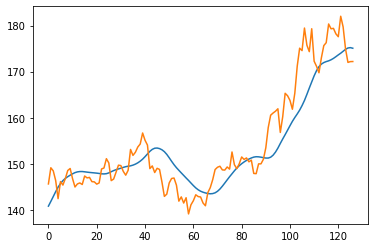

In [11]:
plt.plot(test_predict)
plt.plot(ytest)
plt.show()

In [26]:
# specifying the zip file name
file_name = "AAPL_model.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
AAPL_model/keras_metadata.pb                   2022-01-12 19:16:08        17068
AAPL_model/saved_model.pb                      2022-01-12 19:16:08      2382689
AAPL_model/variables/variables.data-00000-of-00001 2022-01-12 19:16:08       618372
AAPL_model/variables/variables.index           2022-01-12 19:16:08         2731
Extracting all the files now...
Done!


In [110]:
#get the last 100 days and make a prediction
tick = 'AAPL'
def getTestData(ticker, start):
    data = pdr.get_data_yahoo(ticker, start=start, end=today)
    # dataname= ticker+"_"+str(today)
    return data[-100:]
    
   
   
from datetime import datetime, timedelta
start = d = today - timedelta(days=190)

df = getTestData(tick,start) 

#df = pd.DataFrame(stock_data).T
df = df.reset_index()['Close']
df=scaler.transform(np.array(df).reshape(-1,1))
test_data = df.reshape(-1,1)

import keras.models
model = keras.models.load_model(tick + '_model')
prediction = model.predict( np.array( [test_data,] )  )
scaler.inverse_transform(prediction)

[*********************100%***********************]  1 of 1 completed
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replic

array([[174.37128]], dtype=float32)

### Arima

In [73]:
from pmdarima.arima import auto_arima

stock_data = data['AAPL']
df = pd.DataFrame(stock_data).T

data = df.sort_index(ascending=True, axis=0)

train = data[:-2]
valid = data[-2:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.47 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=8903.869, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=8357.856, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=8891.064, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=8009.664, Time=0.47 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=8023.083, Time=0.39 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=8011.656, Time=0.56 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=8011.619, Time=1.13 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=8009.624, Time=0.50 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=8358.974, Time=0.24 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=2.62 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=i

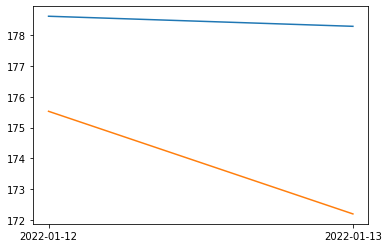

In [74]:
from matplotlib import pyplot as plt

plt.plot(forecast['Prediction'],label='Prediction')
plt.plot(valid['Close'], label='True value')
plt.show()

### Prophet

In [27]:
#importing prophet
from fbprophet import Prophet

stock_data = data['AAPL']
df = pd.DataFrame(stock_data).T

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:-10]
valid = new_data[-10:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

ModuleNotFoundError: No module named 'fbprophet'

### Custom ANN (wih MA, H-L, O-C, etc.)

In [32]:
stock_data = data['AAPL']
df = pd.DataFrame(stock_data).T
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
df['7MA'] = df['Adj Close'].rolling(window=7).mean()
df['14MA'] = df['Adj Close'].rolling(window=14).mean()
df['21MA'] = df['Adj Close'].rolling(window=21).mean()
df['7SD'] = df['Adj Close'].rolling(window=7).std()

features = ['H-L','O-C','7MA','14MA','21MA','7SD','Close']
df_final = df[20:][features].copy()
df_final


,H-L,O-C,7MA,14MA,21MA,7SD,Close
2013-01-30,0.289286,0.006071,14.449076,15.036378,15.491581,0.901975,16.315357
2013-01-31,0.15357,0.053215,14.231595,14.886287,15.378781,0.750963,16.2675
2013-02-01,0.397499,0.196072,13.965085,14.739152,15.238427,0.191794,16.200714
2013-02-04,0.497857,0.413928,13.928986,14.608015,15.091646,0.223532,15.797143
2013-02-05,0.625715,-0.4925,14.008246,14.546055,14.989908,0.176158,16.351429
...,...,...,...,...,...,...,...
2022-01-07,3.110001,0.720001,176.652856,176.445000,176.048095,3.785206,172.169998
2022-01-10,4.330002,-3.110001,175.794285,176.619286,175.935238,4.048253,172.190002
2022-01-11,4.359985,-2.759995,175.438570,176.768571,175.727143,3.974950,175.080002
2022-01-12,2.359985,0.589996,174.512857,176.760714,175.717143,2.757641,175.529999


In [36]:
df_final['Close'] = df['Close'].shift(1)

In [5]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler


In [156]:
features = ['H-L','O-C','7MA','14MA','21MA','7SD']
X = np.asarray(df_final[features], np.float32)
Y = np.asarray(df_final['Close'], np.float32)

from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

scaler_x = StandardScaler().fit(X)
#scaler_y = StandardScaler().fit([y_train])

X = scaler_x.transform(X)
#y_train = scaler_y.transform([y_train])
# Defining the Input layer and FIRST hidden layer, both are same!
model = Sequential()
model.add(Dense(units=10, input_dim=6, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')
 
# Fitting the ANN to the Training set
history = model.fit(X, Y ,batch_size = 20, validation_split = 0.1, epochs = 125, verbose=1)

Epoch 1/125
102/102 [==============================] - 0s 3ms/step - loss: 2574.7957 - val_loss: 20616.0977
Epoch 2/125
102/102 [==============================] - 0s 2ms/step - loss: 2490.4895 - val_loss: 20270.4824
Epoch 3/125
102/102 [==============================] - 0s 2ms/step - loss: 2403.3069 - val_loss: 20038.7852
Epoch 4/125
102/102 [==============================] - 0s 2ms/step - loss: 2337.4875 - val_loss: 19835.5273
Epoch 5/125
102/102 [==============================] - 0s 2ms/step - loss: 2280.7222 - val_loss: 19646.8906
Epoch 6/125
102/102 [==============================] - 0s 2ms/step - loss: 2228.4651 - val_loss: 19467.1777
Epoch 7/125
102/102 [==============================] - 0s 2ms/step - loss: 2179.1841 - val_loss: 19292.9863
Epoch 8/125
102/102 [==============================] - 0s 2ms/step - loss: 2132.1929 - val_loss: 19122.2363
Epoch 9/125
102/102 [==============================] - 0s 2ms/step - loss: 2086.8904 - val_loss: 18956.5664
Epoch 10/125
102/102 [======

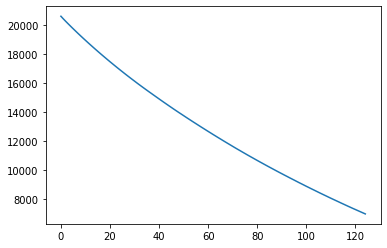

In [146]:
plt.plot(history.history['val_loss'])

In [147]:
#X_test_predict = scaler_x.transform(X_test)
y_pred = model.predict(X_test)

np.sqrt(np.sum((y_pred - y_test)[0]**2))

974.5307

In [107]:
np.sum((y_test - y_pred)[0])

9735.639

In [170]:
test_data

array([[2.3489468],
       [2.0843453],
       [2.903547 ],
       [3.0093894],
       [3.0869222],
       [3.865532 ]], dtype=float32)

In [178]:
test_data

array([[  4.029999 ,   2.0099945, 169.10571  , 172.27214  , 174.21428  ,
          4.8512   ]], dtype=float32)

In [179]:
#df = pd.DataFrame(stock_data).T
df=scaler_x.transform(test_data)
prediction = model.predict(df )
prediction

array([[58.308617]], dtype=float32)

In [171]:
tick = 'AAPL'
import pandas_datareader as pdr
def getTestData(ticker, start):
    data = pdr.get_data_yahoo(ticker, start=start, end=today)
    # dataname= ticker+"_"+str(today)
    return data[-21:]
    
from datetime import date  
today = date.today()

from datetime import datetime, timedelta
start = d = today - timedelta(days=150)

df = getTestData(tick,start) 

In [172]:
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
df['7MA'] = df['Adj Close'].rolling(window=7).mean()
df['14MA'] = df['Adj Close'].rolling(window=14).mean()
df['21MA'] = df['Adj Close'].rolling(window=21).mean()
df['7SD'] = df['Adj Close'].rolling(window=7).std()

In [173]:
df

,High,Low,Open,Close,Volume,Adj Close,H-L,O-C,7MA,14MA,21MA,7SD
Date,,,,,,,,,,,,
2021-12-22,175.860001,172.149994,173.039993,175.639999,92135300.0,175.639999,3.710007,-2.600006,NaN,NaN,NaN,NaN
2021-12-23,176.850006,175.270004,175.850006,176.279999,68356600.0,176.279999,1.580002,-0.429993,NaN,NaN,NaN,NaN
2021-12-27,180.419998,177.070007,177.089996,180.330002,74919600.0,180.330002,3.349991,-3.240005,NaN,NaN,NaN,NaN
2021-12-28,181.330002,178.529999,180.160004,179.289993,79144300.0,179.289993,2.800003,0.870010,NaN,NaN,NaN,NaN
2021-12-29,180.630005,178.139999,179.330002,179.380005,62348900.0,179.380005,2.490005,-0.050003,NaN,NaN,NaN,NaN
2021-12-30,180.570007,178.089996,179.470001,178.199997,59773000.0,178.199997,2.480011,1.270004,NaN,NaN,NaN,NaN
2021-12-31,179.229996,177.259995,178.089996,177.570007,64062300.0,177.570007,1.970001,0.519989,178.098572,NaN,NaN,1.716697
2022-01-03,182.880005,177.710007,177.830002,182.009995,104487900.0,182.009995,5.169998,-4.179993,179.008571,NaN,NaN,1.877065
2022-01-04,182.940002,179.119995,182.630005,179.699997,99310400.0,179.699997,3.820007,2.930008,179.497142,NaN,NaN,1.443508


In [174]:
test_data = np.asarray(df[-1:][features], np.float32)

In [155]:
model.predict(test_data)

array([[61.384346]], dtype=float32)

In [175]:
test_data

array([[  4.029999 ,   2.0099945, 169.10571  , 172.27214  , 174.21428  ,
          4.8512   ]], dtype=float32)